# **1.4 機器學習專案實作 2 - 手寫數字辨識**

使用美國高中生和人口普查局員工手寫的數字圖片來建立數字分類模型，預測手寫數字圖片的數字為何。
參考來源：https://github.com/ageron/handson-ml2/blob/master/03_classification.ipynb

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/y-s-liu/machine-learning-tutorial/blob/master/class1.4_ML_project_2.ipynb)

# 前置作業 - 函式庫環境設置

In [1]:
# Python 版本需大於 3.5
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn 版本需大於 0.20
import sklearn
assert sklearn.__version__ >= "0.20"

# 共通函式庫
import numpy as np
import os

# 繪圖函式庫與參數設置
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 實驗圖片存檔位置
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "class4"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
    
# 設定亂數產生種子
np.random.seed(42)

# 前置作業 - 資料下載(輸入：下載MNIST資料集，輸出：X, y)

In [2]:
# 下載資料
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
# 資料集的資料與標籤的
X, y = mnist["data"], mnist["target"]

# 指定標籤資料型態為 uint8 (預設標籤的資料型態是文字)
y = y.astype(np.uint8)

print(X.shape)
print(y.shape) # 28 * 28 = 784

(70000, 784)
(70000,)


Saving figure some_digit_plot


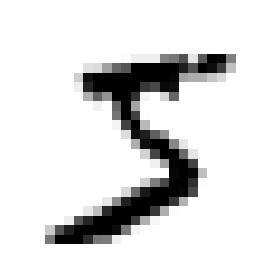

圖片標籤： 5


In [4]:
# 顯示其中一張圖片
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

print("圖片標籤：", y[0])

Saving figure more_digits_plot


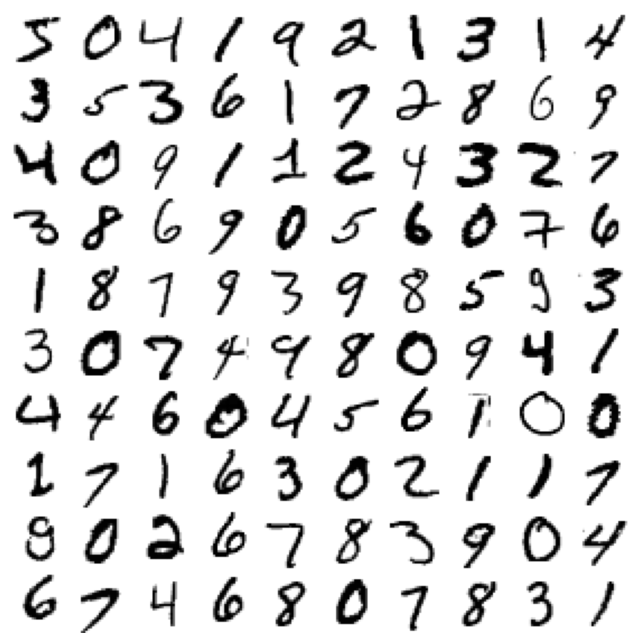

In [5]:
# 繪製資料集的一些圖片，藉此瞭解圖片樣態，可看出資料已經被打亂了
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

# 分割資料集(輸入：X, y，輸出：X_train, X_test, y_train, y_test)

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 訓練二元分類器

In [7]:
# 此次任務是分辨 "5" 與 "非5"
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

**Note**: some hyperparameters will have a different defaut value in future versions of Scikit-Learn, such as `max_iter` and `tol`. To be future-proof, we explicitly set these hyperparameters to their future default values. For simplicity, this is not shown in the book.

In [8]:
from sklearn.linear_model import SGDClassifier

# 選擇SGD分類模型
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)

# 模型訓練
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [9]:
# 模型預測 (some_digit 是數字 5 的圖片)
sgd_clf.predict([some_digit])

array([ True])

# 用交叉驗證評估準確率

In [10]:
# 使用 sklearn 所提供的函式
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [11]:
# 自行實作
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

D:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


0.95035
0.96035
0.9604


# 計算混淆矩陣

In [12]:
# 計算混淆矩陣
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [13]:
# 假設是一個完美的結果
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [14]:
# 計算 precision ， TP / (TP + FP)=3530 / (3530 + 687)
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [15]:
# 計算 recall ， TP / (TP + FN)=3530 / (3530 + 1891)
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [16]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [17]:
# 取得分類的分數
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [18]:
# 預設的分類門檻值為 0
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [19]:
# 若將分類門檻值為 8000
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [20]:
# 先使用 cross_val_predict 函式來取得訓練資料集的所有分數
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [21]:
# 使用precision_recall_curve來計算所有可能的門檻值
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Saving figure precision_recall_vs_threshold_plot


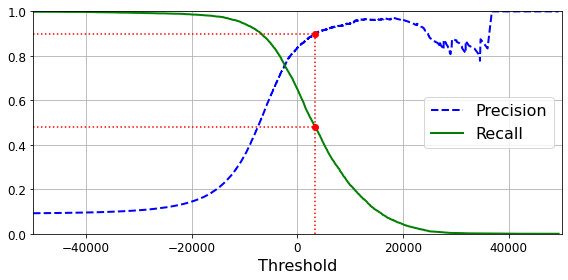

In [22]:
# 畫出 precision 和 recall 的曲線圖，方便未來可以訂出門檻值

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

Saving figure precision_vs_recall_plot


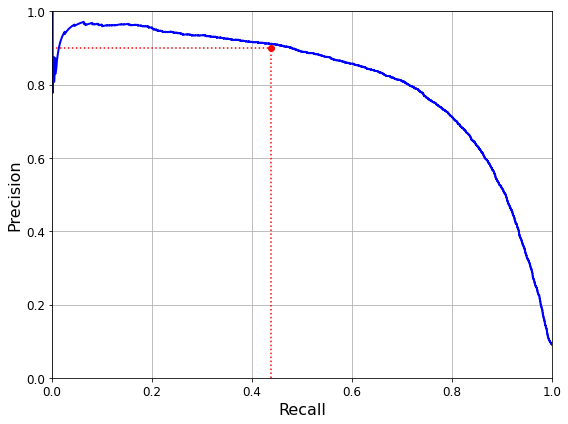

In [23]:
# 畫出 precision 和 recall 的關係圖，方便未來可以訂出門檻值

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

In [24]:
# 設定門檻值為大於 90 precision 
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
print('threshold_90_precision : ', threshold_90_precision)

y_train_pred_90 = (y_scores >= threshold_90_precision)

print('precision_score : ', precision_score(y_train_5, y_train_pred_90))
print('recall_score : ', recall_score(y_train_5, y_train_pred_90))

threshold_90_precision :  3370.0194991439557
precision_score :  0.9000345901072293
recall_score :  0.4799852425751706


# 計算 ROC 曲線

In [25]:
# 計算出 ture positive 與 false positive 的機率值
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Saving figure roc_curve_plot


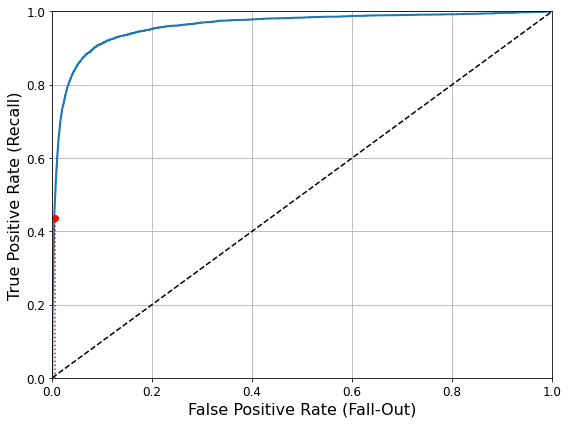

In [26]:
# 畫出 ROC 曲線
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
save_fig("roc_curve_plot")                         # Not shown
plt.show()

In [27]:
# AUC 是計算曲線下的區域面積，完美是 1，純隨機分類器是 0.5
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [28]:
# 接下來試試看隨機森林分類器，並且可與 SGD 分類器做比較
from sklearn.ensemble import RandomForestClassifier
# 選擇隨機森林分類模型
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
# 使用 k-fold 方法訓練隨機森林分類模型
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [29]:
# 計算 ROC 曲線所需 ture positive 與 false positive 的機率值
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

Saving figure roc_curve_comparison_plot


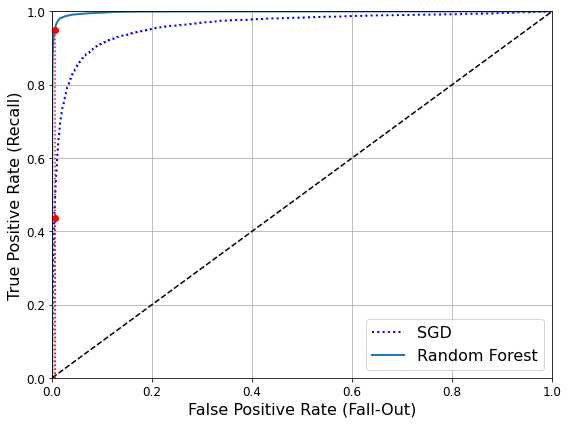

In [30]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], "r:")
plt.plot([4.837e-3], [0.9487], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [31]:
# 計算隨機森林分類器的 AUC
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [32]:
# 計算 precision
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [33]:
# 計算 recall
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591